# Yvettes Notebook

In [330]:
import os
import json
from typing import Dict, List, Optional, Union, cast
import requests
from bs4 import BeautifulSoup
from env import github_token, github_username
import re
import pandas as pd
import time
import prepare as p
from sklearn.model_selection import train_test_split
import nltk.sentiment

### Acquire webscrape urls from repos and save to csv

Keytakaway from urls collection:
After some exploration of urls in github search of most starred repos we noticed that the page number in the url was the only change from one page to another. Creating a loop to change page when web scraping will allow us to 
iterate through pages and get more urls into our csv file.

We also notice that the link to the repo was under <a> class = "v-align-middle". We will add a forloop to scrape each link and remove the first "/" and save into csv file.
    
In total we were able to collect 1000 observation of urls 853 of which seem to be unique.

In [2]:
    #'search?q=stars%3A%3E0&s=stars&type=Repositories'
    #'search?p=2&q=stars%3A%3E0&s=stars&type=Repositories'
    #'search?p=3&q=stars%3A%3E0&s=stars&type=Repositories'
    
#https://github.com/search?q=stars%3A%3E0&s=stars&type=Repositories
#https://github.com/search?p=100&q=stars%3A%3E0&s=stars&type=Repositories

In [3]:
#urls=[]
#for i in range(0,100):
#    url = f"https://github.com/search?p={i}&q=stars%3A%3E0&s=stars&type=Repositories"
#    reqs = requests.get(url)
#    soup = BeautifulSoup(reqs.text, 'html.parser')
#    time.sleep(2)
#    for link in soup.find_all('a',class_="v-align-middle"):
#        link = re.sub(r'/', '', link.get('href'), count = 1)
#        urls.append(link)
#        time.sleep(1)
    

In [4]:
#urls =pd.DataFrame(urls)

In [5]:
#urls.nunique()

In [6]:
#urls.to_csv('urls_final1.csv', index=False)

### prep of  urls  

We will call on our saved urls_final.csv file to scrape the content of the repos of ReadMe text, main language of code. We will then save the information along with the repos name into a data frame.

In [136]:
urls_repo = pd.read_csv('urls_final.csv', index_col=0)
urls_repo

,0
0,freeCodeCamp/freeCodeCamp
1,getify/You-Dont-Know-JS
2,microsoft/vscode
3,electron/electron
4,axios/axios
...,...
995,attic-labs/noms
996,libretro/RetroArch
997,score-spec/spec
998,ThreeMammals/Ocelot


In [137]:
urls_repo.head()

,0
0,freeCodeCamp/freeCodeCamp
1,getify/You-Dont-Know-JS
2,microsoft/vscode
3,electron/electron
4,axios/axios


In [138]:
urls_repo.nunique()

0    853
dtype: int64

In [139]:
urls_repo.drop_duplicates(inplace=True)

In [140]:
urls_repo[460:470]

,0
526,bootstrap-vue/bootstrap-vue
527,sharkdp/hyperfine
528,Rigellute/spotify-tui
529,williamfiset/Algorithms
530,jina-ai/jina
531,dropzone/dropzone
532,ethereumbook/ethereumbook
533,chaozh/awesome-blockchain-cn
534,eip-work/kuboard-press
535,semantic-release/semantic-release


In [141]:
urls_repo.iloc[468]

0    eip-work/kuboard-press
Name: 534, dtype: object

In [162]:
# scrapping functions where not functionin properly because url index 468 no longer existed, so it was dropped.
#0    eip-work/kuboard-press
#Name: 534, dtype: object
#urls_repo.drop([534], axis = 0, inplace= True)

In [163]:
urls_repo[460:470]

,0
460,bootstrap-vue/bootstrap-vue
461,sharkdp/hyperfine
462,Rigellute/spotify-tui
463,williamfiset/Algorithms
464,jina-ai/jina
465,dropzone/dropzone
466,ethereumbook/ethereumbook
467,chaozh/awesome-blockchain-cn
468,semantic-release/semantic-release
469,framework7io/framework7


In [148]:
urls_repo.reset_index(inplace=True)

In [149]:
urls_repo.drop(columns=['index'], inplace=True)

In [150]:
urls_repo.head()

,0
0,freeCodeCamp/freeCodeCamp
1,getify/You-Dont-Know-JS
2,microsoft/vscode
3,electron/electron
4,axios/axios


In [164]:
urls_repo.iloc[466]

0    ethereumbook/ethereumbook
Name: 466, dtype: object

### acquire readmes from github using urls

In [153]:
"""
A module for obtaining repo readme and language data from the github API.
Before using this module, read through it, and follow the instructions marked
TODO.
After doing so, run it like this:
    python acquire.py
To create the `data.json` file that contains the data.
"""


# TODO: Make a github personal access token.
#     1. Go here and generate a personal access token: https://github.com/settings/tokens
#        You do _not_ need select any scopes, i.e. leave all the checkboxes unchecked
#     2. Save it in your env.py file under the variable `github_token`
# TODO: Add your github username to your env.py file under the variable `github_username`
# TODO: Add more repositories to the `REPOS` list below.

REPOS = urls_repo['0']

0-250 seem okay 
250-500  had an error
460-470 had an error
480-500 was good
Repo index number 468 eip-work/kuboard-press no longer exists and is causing problems. # 468 will be dropped from csv



In [154]:
headers = {"Authorization": f"token {github_token}", "User-Agent": github_username}

if headers["Authorization"] == "token " or headers["User-Agent"] == "":
    raise Exception(
        "You need to follow the instructions marked TODO in this script before trying to use it"
    )

In [155]:
def github_api_request(url: str) -> Union[List, Dict]:
    response = requests.get(url, headers=headers)
    response_data = response.json()
    if response.status_code != 200:
        raise Exception(
            f"Error response from github api! status code: {response.status_code}, "
            f"response: {json.dumps(response_data)}"
        )
    return response_data


def get_repo_language(repo: str) -> str:
    url = f"https://api.github.com/repos/{repo}"
    repo_info = github_api_request(url)
    if type(repo_info) is dict:
        repo_info = cast(Dict, repo_info)
        if "language" not in repo_info:
            raise Exception(
                "'language' key not round in response\n{}".format(json.dumps(repo_info))
            )
        return repo_info["language"]
    raise Exception(
        f"Expecting a dictionary response from {url}, instead got {json.dumps(repo_info)}"
    )


def get_repo_contents(repo: str) -> List[Dict[str, str]]:
    url = f"https://api.github.com/repos/{repo}/contents/"
    contents = github_api_request(url)
    if type(contents) is list:
        contents = cast(List, contents)
        return contents
    raise Exception(
        f"Expecting a list response from {url}, instead got {json.dumps(contents)}"
    )


def get_readme_download_url(files: List[Dict[str, str]]) -> str:
    """
    Takes in a response from the github api that lists the files in a repo and
    returns the url that can be used to download the repo's README file.
    """
    for file in files:
        if file["name"].lower().startswith("readme"):
            return file["download_url"]
    return ""


def process_repo(repo: str) -> Dict[str, str]:
    """
    Takes a repo name like "gocodeup/codeup-setup-script" and returns a
    dictionary with the language of the repo and the readme contents.
    """
    contents = get_repo_contents(repo)
    readme_download_url = get_readme_download_url(contents)
    if readme_download_url == "":
        readme_contents = ""
    else:
        readme_contents = requests.get(readme_download_url).text
    return {
        "repo": repo,
        "language": get_repo_language(repo),
        "readme_contents": readme_contents,
    }


def scrape_github_data() -> List[Dict[str, str]]:
    """
    Loop through all of the repos and process them. Returns the processed data.
    """
    return [process_repo(repo) for repo in REPOS]

In [156]:
if __name__ == "__main__":
    try:
        data = scrape_github_data()
        json.dump(data, open("data.json", "w"), indent=1)
    except: 
        pass

In [157]:
# scrape repos for information.
#df = scrape_github_data()

In [265]:
#df = pd.DataFrame(df)

In [266]:
#df.head()

,repo,language,readme_contents,target_language
0,freeCodeCamp/freeCodeCamp,TypeScript,[![freeCodeCamp Social Banner](https://s3.amaz...,TypeScript
2,microsoft/vscode,TypeScript,"# Visual Studio Code - Open Source (""Code - OS...",TypeScript
3,electron/electron,C++,[![Electron Logo](https://electronjs.org/image...,other
4,axios/axios,JavaScript,"<h1 align=""center"">\n <b>\n <a href=""...",JavaScript
5,microsoft/TypeScript,TypeScript,\r\n# TypeScript\r\n\r\n[![GitHub Actions CI](...,TypeScript


Final data was scaped 1/11/2023 at 10pm

### Prepare Data

In [267]:
#create csv to save
#df.to_csv('readme_df.csv', index = False)

In [296]:
df = pd.read_csv('readme_df.csv')
df

,repo,language,readme_contents
0,freeCodeCamp/freeCodeCamp,TypeScript,[![freeCodeCamp Social Banner](https://s3.amaz...
1,getify/You-Dont-Know-JS,NaN,# You Don't Know JS Yet (book series) - 2nd Ed...
2,microsoft/vscode,TypeScript,"# Visual Studio Code - Open Source (""Code - OS..."
3,electron/electron,C++,[![Electron Logo](https://electronjs.org/image...
4,axios/axios,JavaScript,"<h1 align=""center"">\n <b>\n <a href=""..."
...,...,...,...
847,nodejs/docker-node,Dockerfile,# Node.js\n\n[![dockeri.co](http://dockeri.co/...
848,cloudflare/cfssl,Go,# CFSSL\n\n[![Build Status](https://travis-ci....
849,leeoniya/uPlot,JavaScript,## 📈 μPlot\n\nA small ([~40 KB min](https://gi...
850,score-spec/spec,NaN,# Score\n\n![Score banner](/docs/images/banner...


In [297]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 852 entries, 0 to 851
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   repo             852 non-null    object
 1   language         771 non-null    object
 2   readme_contents  847 non-null    object
dtypes: object(3)
memory usage: 20.1+ KB


In [298]:
df.dropna(inplace=True)

In [299]:
df.shape

(768, 3)

In [303]:
df = df[(df.language == 'Java') | (df.language=='JavaScript') | (df.language=='Python') | (df.language=='TypeScript')]

In [309]:
df.reset_index(drop =True, inplace=True)

In [311]:
df

,repo,language,readme_contents
0,freeCodeCamp/freeCodeCamp,TypeScript,[![freeCodeCamp Social Banner](https://s3.amaz...
1,microsoft/vscode,TypeScript,"# Visual Studio Code - Open Source (""Code - OS..."
2,axios/axios,JavaScript,"<h1 align=""center"">\n <b>\n <a href=""..."
3,microsoft/TypeScript,TypeScript,\r\n# TypeScript\r\n\r\n[![GitHub Actions CI](...
4,tensorflow/models,Python,"<div align=""center"">\n <img src=""https://stor..."
...,...,...,...
372,jquery-form/form,JavaScript,# jQuery Form [![Build Status](https://travis-...
373,Mailtrain-org/mailtrain,JavaScript,# Mailtrain v2\n\nMailtrain is a self hosted n...
374,google/error-prone,Java,# Error Prone\n\nError Prone is a static analy...
375,pentaho/pentaho-kettle,Java,# Pentaho Data Integration # \n\nPentaho Data ...


In [312]:
df.language.value_counts()

JavaScript    169
Python         88
Java           62
TypeScript     58
Name: language, dtype: int64

In [313]:
df.language.isnull().sum()

0

### More Prep

In [317]:
# apply basic clean to content
df['clean_text']= df.readme_contents.apply(p.basic_clean)

In [318]:
# apply tokenize 
df['clean_text']= df.clean_text.apply(p.tokenize)

In [319]:
# lemmatize
df['clean_text']= df.clean_text.apply(p.lemmatize)

In [320]:
# remove stopwords
df['clean_text']= df.clean_text.apply(p.remove_stopwords)

In [321]:
df

,repo,language,readme_contents,clean_text
0,freeCodeCamp/freeCodeCamp,TypeScript,[![freeCodeCamp Social Banner](https://s3.amaz...,freecodecamp social bannerhttpss3amazonawscomf...
1,microsoft/vscode,TypeScript,"# Visual Studio Code - Open Source (""Code - OS...",visual studio code open source code os feature...
2,axios/axios,JavaScript,"<h1 align=""center"">\n <b>\n <a href=""...",h1 aligncenter b hrefhttpsaxioshttpcomimg srch...
3,microsoft/TypeScript,TypeScript,\r\n# TypeScript\r\n\r\n[![GitHub Actions CI](...,typescript github action cihttpsgithubcommicro...
4,tensorflow/models,Python,"<div align=""center"">\n <img src=""https://stor...",div aligncenter img srchttpsstoragegoogleapisc...
...,...,...,...,...
372,jquery-form/form,JavaScript,# jQuery Form [![Build Status](https://travis-...,jquery form build statushttpstravisciorgjquery...
373,Mailtrain-org/mailtrain,JavaScript,# Mailtrain v2\n\nMailtrain is a self hosted n...,mailtrain v2 mailtrain self hosted newsletter ...
374,google/error-prone,Java,# Error Prone\n\nError Prone is a static analy...,error prone error prone static analysis tool j...
375,pentaho/pentaho-kettle,Java,# Pentaho Data Integration # \n\nPentaho Data ...,pentaho data integration pentaho data integrat...


# Split data

In [322]:
def split_data(df, target):
    '''
    split_date takes in a dataframe  and target variable and splits into train , validate, test 
    and stratifies on target variable
    
    The split is 20% test 80% train/validate. Then 30% of 80% validate and 70% of 80% train.
    Aproximately (train 56%, validate 24%, test 20%)
    
    returns train, validate, and test 
    '''
    # split test data from train/validate
    train_validate, test = train_test_split(df, test_size=.2, 
                                        random_state=123, 
                                        stratify=df[target])

    # split train from validate
    train, validate = train_test_split(train_validate, test_size=.3, 
                                   random_state=123, 
                                   stratify=train_validate[target])

                                   
    return train, validate, test

In [326]:
train, validate, test = split_data(df,'language')

Int64Index([147,  80, 320,  66, 150, 346,  40,  14, 105, 361,
            ...
            199,  49, 239,   1, 220, 372, 125, 117, 124, 263],
           dtype='int64', length=210)

# Explore

### look at how many of each type

# Question is there a difference in sentimate by language?

In [340]:
sentimate_df = train[['language','clean_text']]

In [344]:
sentimate_df.reset_index(drop =True, inplace=True)

In [345]:
sia = nltk.sentiment.SentimentIntensityAnalyzer()

In [362]:
temp=[]
for i in range(len(sentimate_df)):    
    score = sia.polarity_scores(sentimate_df.clean_text[i])
    temp.append(score)

In [368]:
sentimate_df["row_id"] =sentimate_df.index 

In [369]:
df_subset = sentimate_df[['row_id', 'clean_text']].copy()

In [364]:
# set up empty dataframe for staging output
df1=pd.DataFrame()
df1['row_id']=['99999999999']
df1['sentiment_type']='NA999NA'
df1['sentiment_score']=0

In [372]:
print('Processing sentiment analysis...')
# sid = SentimentIntensityAnalyzer()
t_df = df1
for index,row in df_subset.iterrows():
    scores = sia.polarity_scores(row[1])
    for key, value in scores.items():
        temp = [key,value,row[0]]
        df1['row_id']=row[0]
        df1['sentiment_type']=key
        df1['sentiment_score']=value
        t_df=t_df.append(df1)
#remove dummy row with row_id = 99999999999
t_df_cleaned = t_df[t_df.row_id != '99999999999']
#remove duplicates if any exist
t_df_cleaned = t_df_cleaned.drop_duplicates()
# only keep rows where sentiment_type = compound
t_df_cleaned = t_df[t_df.sentiment_type == 'compound']
print(t_df_cleaned.head(10))

Processing sentiment analysis...
   row_id sentiment_type  sentiment_score
0       0       compound           0.9901
0       1       compound           0.2732
0       2       compound           0.9921
0       3       compound           0.8481
0       4       compound           0.9949
0       5       compound           0.9702
0       6       compound           0.9403
0       7       compound           0.9862
0       8       compound           0.4019
0       9       compound           0.9995


In [374]:
#merge dataframes
df_output = pd.merge(sentimate_df, t_df_cleaned, on='row_id', how='inner')
print(df_output.head(10))

     language                                         clean_text  row_id  \
0  JavaScript  pure purehttpscloudgithubusercontentcomassets4...       0   
1  JavaScript  fis3 demo fis3 fis3 uselessuseless le usesassu...       1   
2  JavaScript  accountingjs tiny javascript library number mo...       2   
3  JavaScript  api nodejs api service p hrefhttpswwwnpmjscomp...       3   
4  TypeScript  ngxadmin img srchttpsiimgurcomomcxwz0png altev...       4   
5        Java  lawnchair 121 build debug apkhttpsgithubcomlaw...       5   
6  JavaScript  algorithm javascript front matter javascript r...       6   
7  JavaScript  notice development project ha suspended due la...       7   
8  JavaScript  luxon mit licenselicenseimagelicense build sta...       8   
9      Python  div aligncenter img srchttpsgithubcomfmfnbayes...       9   

  sentiment_type  sentiment_score  
0       compound           0.9901  
1       compound           0.2732  
2       compound           0.9921  
3       compound   

In [375]:
df_output[["sentiment_score"]].describe()

,sentiment_score
count,210.000000
mean,0.772840
std,0.451652
min,-0.992800
25%,0.846450
50%,0.983650
75%,0.996150
max,1.000000


<AxesSubplot:title={'center':'Sentiment Score'}, xlabel='Period', ylabel='Mean Sentiment Score'>

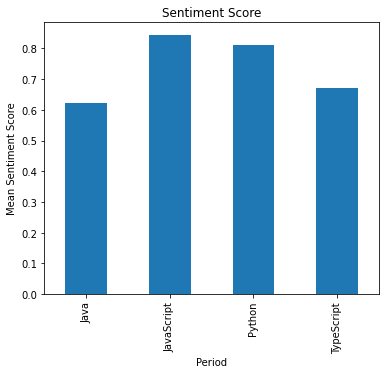

In [377]:
#generate mean of sentiment_score by period
dfg = df_output.groupby(['language'])['sentiment_score'].mean()
#create a bar plot
dfg.plot(kind='bar', title='Sentiment Score', ylabel='Mean Sentiment Score',
         xlabel='Period', figsize=(6, 5))

# Are the top 10 trigrams/bigrams the same accross languages?

# From the top 10 words per language,Is there shared words?